## Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
import pandas as pd
import numpy as np
import os
from ann_visualizer.visualize import ann_viz
from keras.layers import Dense, Input, InputLayer, Flatten , Dropout
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout , BatchNormalization
from keras import regularizers as rz
from keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import  StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential, Model
from  matplotlib import pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import matplotlib.image as mpimg
import os
%matplotlib inline

In [1]:
input_dir="/Users/snouto/Downloads/output2"
data_dir = "/Users/snouto/Downloads/melanoma"
metadata_file="/Users/snouto/Documents/melanoma_deeplearning/HAM10000_metadata.csv"
input_shape=(64,64,3)
epochs=5 # training the neural network with all the training data for one cycle.
kernel_size= (3,3) # specifying the height and width of the 2D convolution window. 
batch_size=1 # number of samples that will be propagated through the network.

# You can control the number of classes from below 
# and don't forget to change loss function if num_classes > 2 to categorical_crossentropy
# and the activation into softmax
num_classes=2
loss_func='binary_crossentropy'
activation='sigmoid'# activation function of a node defines the output of that node given an input or set of inputs.

## Explanatory Data Analysis

In [4]:
metadata = pd.read_csv(metadata_file)
metadata.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/snouto/Documents/melanoma_deeplearning/HAM10000_metadata.csv'

In [4]:
metadata.dx.unique()
# mel(Melanoma),bcc(Basal cell carcinoma),akiec(Actinic keratoses)--->cancer

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [5]:
metadata.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


<AxesSubplot:>

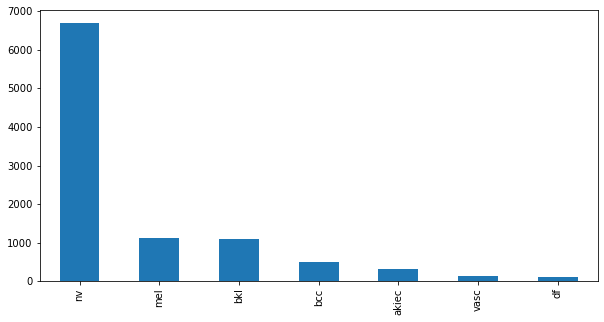

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
metadata['dx'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot:>

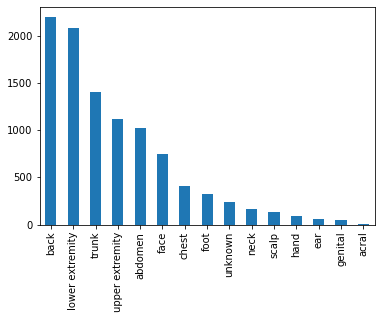

In [8]:
metadata['localization'].value_counts().plot(kind='bar')

In [9]:
indexes = metadata[metadata['sex'] == 'unknown'].index

In [10]:
metadata.drop(indexes,inplace=True)

<AxesSubplot:>

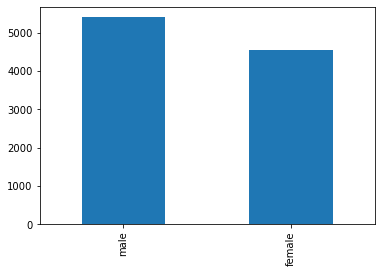

In [11]:
metadata['sex'].value_counts().plot(kind='bar')

In [12]:
metadata.dropna(inplace=True)

## Functions

In [13]:
#output_dir = "/home/genomicslab/nn/out"
# This function will prepare images directory that will act as an input directory for ImageDataGenerator
def prepare_input_features(data_path,metadata_file,output_dir):
    import os , shutil
    import pandas as pd
    from sklearn.model_selection import train_test_split
    if not os.path.exists(data_path):
        raise Exception("Data Path doesn't exist")
    if not metadata_file:
        raise Exception("Please specify a metadata file to load")

    print(f"Loading metadata from : {metadata_file}")
    metadata = pd.read_csv(metadata_file)
    metadata_train,metadata_test = train_test_split(metadata,test_size=0.1)
    metadata_train, metadata_val = train_test_split(metadata_train,test_size=0.1)
    print(f"Preparing features to output Directory : {output_dir}")
    all_data = [("train",metadata_train),("test",metadata_test),("val",metadata_val)]
    for ds_type , df in all_data:
        print(f"Preparing {ds_type}.......")
        for index, row in df.iterrows():
            output_dir_name = os.path.join(output_dir,ds_type,row['dx'])
            if not os.path.exists(output_dir_name):
                os.makedirs(output_dir_name)
            data_img_loc = os.path.join(data_path,f"{row['image_id']}.jpg")
            if not os.path.exists(data_img_loc):
                continue
            shutil.move(data_img_loc,output_dir_name)
            print(f"Moved: {data_img_loc}")
        print(f"#"*100)

    print("All Input Features Prepared")

In [14]:
def show_images(img_loc,display_size=(3,2)):
    from matplotlib import pyplot as plt
    import random
    from collections import defaultdict
    import cv2
    plt.figure(figsize = (20,20))
    bucket = defaultdict(list)
    if not img_loc:
        raise Exception("Provide image directory. It should not be empty")
    classes = [os.path.join(img_loc,d) for d in os.listdir(img_loc)]
    random.shuffle(classes)
    for cls in range(0,display_size[0]):
        curr_cls = classes[cls]
        counter = 0
        for img in os.listdir(curr_cls):
            if counter >= display_size[1]:
                break
            curr_file = os.path.join(curr_cls,img)
            bucket[os.path.basename(curr_cls)].append(cv2.imread(curr_file))
            counter += 1
    rows ,  cols = display_size
    counter = 1
    for key in bucket.keys():
        imgs = bucket[key]
        for img in imgs:
            plt.subplot(rows,cols,counter)
            plt.imshow(img,interpolation='nearest', aspect='auto')
            counter += 1

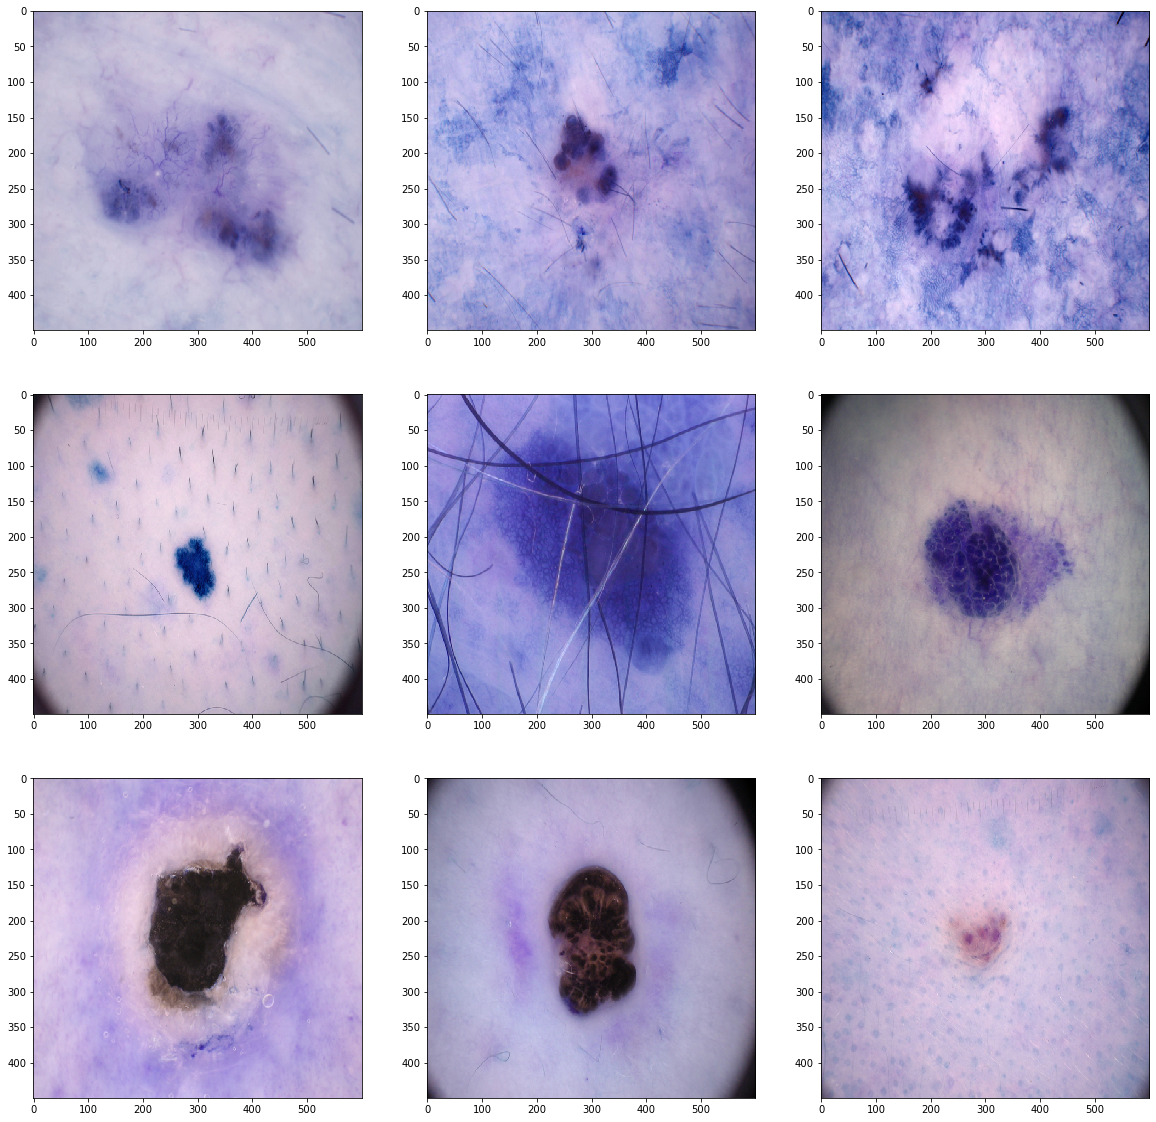

In [15]:
show_images("/Users/snouto/Downloads/output/train",display_size=(3,3))


## Image Augmentation (Generating rotated, skewed and scaled) images

In [17]:
# this function will generate different images based on the image augementation chosen 
#in the image Data Generator instance
def generate_augmentation(generator: ImageDataGenerator,folder,files_size=50,augment_size=10,prefix='augmented'):
    from keras.preprocessing import image
    for root , dirs , files in os.walk(folder,topdown=False):
        for file in files[:files_size]:
            file_loc = os.path.join(root,file)
            bn = os.path.basename(file_loc)
            _ , ext = os.path.splitext(file_loc)
            ext = ext.replace('.','')
            if not ext.lower() in ['jpeg','jpg','png']:
                continue
            img = image.load_img(file_loc)
            image_arr = image.img_to_array(img)
            image_arr = image_arr.reshape((1,) + image_arr.shape)
            counter = 0 
            for _ in generator.flow(image_arr,batch_size=2,save_to_dir=root,save_prefix=f"{bn}.{prefix}",save_format=ext):
                counter += 1
                print(f"{counter}. Augmented Image saved to : {os.path.join(root,bn+'.'+prefix)}")
                if counter > augment_size:
                    break

In [19]:
#generate_augmentation(image_datagen,folder=os.path.join(input_dir,"val"),files_size=50)

## Helper Functions

In [20]:
def get_generators():
    # Creating the training Generator
    image_datagen = ImageDataGenerator( rescale=1 / 255.0,
                                          rotation_range=20,
                                          zoom_range=0.05,
                                          width_shift_range=0.05,
                                          height_shift_range=0.05,
                                          shear_range=0.05,
                                          horizontal_flip=True,
                                          fill_mode="nearest",
                                          validation_split=0.20)

    train_generator = image_datagen.flow_from_directory(
        directory=os.path.join(input_dir,"train"),
        target_size=(input_shape[0],input_shape[1]),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        subset='training',
        
        seed=42
    )
    val_generator = image_datagen.flow_from_directory(
        directory=os.path.join(input_dir,"val"),
        target_size=(input_shape[0],input_shape[1]),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        subset='validation',
        
        seed=42
    )
    test_generator = image_datagen.flow_from_directory(
        directory=os.path.join(input_dir,"test"),
        target_size=(input_shape[0],input_shape[1]),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        
        
        seed=42
    )
    
    return train_generator, test_generator , val_generator , image_datagen



In [21]:
# this function takes in a generator and returns a generator with correct labels
def trainer(generator):
    from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
    BENIGN,MALIGNANT = 0,1
    for filepath in generator.filepaths:
        curr_cls = np.zeros(len(generator.class_indices))
        if 'benign' in filepath:
            curr_cls[BENIGN] = 1
        elif 'malignant' in filepath:
            curr_cls[MALIGNANT] = 1
        current_img = load_img(filepath, target_size=(input_shape[0],input_shape[1]))
        current_img  = img_to_array(current_img)
        current_img = current_img.reshape((1, current_img.shape[0], current_img.shape[1], current_img.shape[2]))
        yield current_img , curr_cls.reshape(1,len(generator.class_indices))

In [22]:
def predict_img(model,img_path):
    from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
    BENIGN,MALIGNANT = 0,1
    current_img = load_img(img_path, target_size=(input_shape[0],input_shape[1]))
    current_img  = img_to_array(current_img)
    current_img = current_img.reshape((1, current_img.shape[0], current_img.shape[1], current_img.shape[2]))
    return model.predict(current_img)
    

In [23]:
def plot_acc(hist,title='Model Accuracy'):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch(s)')
    plt.legend(['train','test'],loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Baseline Model(s)



In [24]:
# Creating the training Generator
train_generator , test_generator , val_generator , image_datagen = get_generators()

Found 6491 images belonging to 7 classes.
Found 178 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [25]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

create_xgb_model = lambda :  xgb.XGBClassifier( 
                       )

create_ab_model = lambda : AdaBoostClassifier()
create_knn_model = lambda : KNeighborsClassifier()

bl_model = KNeighborsClassifier()


In [26]:
def get_features(generator,sample_size=4000):
    x_train = []
    y_train = []
    counter = 0 
    for x,y in train_generator:
        counter += 1
        x_train.append(x)
        y_train.append(y)
        if counter >= sample_size:
            break

    final_shape = (len(x_train),input_shape[0]*input_shape[1]*input_shape[2])
    x_features = np.reshape(x_train,final_shape)
    return x_features , np.array([np.argmax(y) for y in y_train]).astype('int')

In [27]:
def reduce_dimensions(x_train_total,window_size=1000):
    total = []
    for j in range(x_train_total.shape[0]):
        x_train_new = []
        x_train = np.array(x_train_total[j])
        L = x_train.shape[0]
        odds = L % window_size
        new_L = L - odds
        loops = int(new_L / window_size)
        for i in range(int(loops)):
            i = int(i)
            ma = np.mean(x_train[int(i*window_size):int(window_size+(i*window_size)+1)])
            x_train_new.append(ma)
        last_mean = x_train[loops*window_size:window_size+(i*window_size)+1]
        x_train_new.append(last_mean)
        total.append(x_train_new)
    scaler = StandardScaler()
    output = np.array(total)
    output = scaler.fit_transform(output)
    return output
    
    
    

## Training BaseLine Model

In [28]:
x_train , y_train = get_features(train_generator)

In [29]:
x_train_reduced = reduce_dimensions(x_train)

In [580]:
x_train_reduced.shape

(4000, 13)

In [581]:
x_train_reduced

array([[ 0.35440689,  0.31435639,  0.14879607, ...,  0.27188514,
         0.35245044,  0.79251606],
       [ 0.79382883,  0.92696504,  1.15582092, ...,  1.07507581,
         0.99652099, -0.26081132],
       [-0.52015563, -0.40356674, -0.13613141, ..., -0.96391017,
        -1.20500576, -1.2559726 ],
       ...,
       [ 0.86576319,  0.83908475,  0.5084059 , ...,  0.83875077,
         0.85577348,  1.08162665],
       [-0.69090242, -0.81353376, -0.99596858, ..., -1.56329462,
        -1.32708093, -0.15885861],
       [-0.41196676, -0.19787247,  0.22900988, ..., -0.37291217,
        -0.61265404, -0.68129973]])

In [582]:
# Do Training
bl_model.fit(x_train_reduced,pd.Series(y_train))

KNeighborsClassifier()

## Baseline Train Accuracy

In [583]:
x_train , y_train = get_features(train_generator)
x_train = reduce_dimensions(x_train)
y_train_pred = bl_model.predict(x_train)
accuracy_score(y_train,y_train_pred)

<ipython-input-577-6906ffcd43d0>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output = np.array(total)


0.63925

## Baseline Validation Accuracy

In [584]:
x_validation , y_validation = get_features(val_generator)
x_validation = reduce_dimensions(x_validation)
y_val_pred = bl_model.predict(x_validation)
accuracy_score(y_validation,y_val_pred)

<ipython-input-577-6906ffcd43d0>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output = np.array(total)


0.672

## Baseline Test Accuracy

In [585]:
# Test 
x_test , y_test = get_features(test_generator)
x_test = reduce_dimensions(x_test)

<ipython-input-577-6906ffcd43d0>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output = np.array(total)


In [586]:
y_test_pred = bl_model.predict(x_test)

In [587]:
# Perform accuracy report
accuracy_score(y_test,y_test_pred)

0.67325

##  Neural net builder Function



In [32]:
def get_nn_model(layers=[]):
    model = keras.Sequential([
    keras.layers.InputLayer(input_shape=input_shape),
    Flatten(),
    keras.layers.Dense(128,input_dim=input_shape[0]*input_shape[1]*input_shape[2]),
    keras.layers.Dense(units=128, activation="relu"),
])
    for layer in layers:
        model.add(layer)
    model.add(keras.layers.Dense(units=num_classes, activation=activation))
    model.compile("adam", loss=loss_func, metrics=["acc"])
    return model
##simple nural network 

## Simple NN Model

In [61]:
# Creating the training Generator
train_generator , test_generator , val_generator , image_datagen = get_generators()

Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [62]:
simple_nn = get_nn_model()
simple_nn_hist = simple_nn.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
6490/6490 [==============================] - 90s 14ms/step - loss: 0.9113 - acc: 0.7814 - val_loss: 0.4177 - val_acc: 0.8333
Epoch 2/10
6490/6490 [==============================] - 194s 30ms/step - loss: 0.5590 - acc: 0.8009 - val_loss: 0.4602 - val_acc: 0.8333
Epoch 3/10
6490/6490 [==============================] - 95s 15ms/step - loss: 0.4983 - acc: 0.8017 - val_loss: 0.4528 - val_acc: 0.8333
Epoch 4/10
6490/6490 [==============================] - 89s 14ms/step - loss: 0.4983 - acc: 0.8017 - val_loss: 0.4535 - val_acc: 0.8333
Epoch 5/10
6490/6490 [==============================] - 95s 15ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4540 - val_acc: 0.8333
Epoch 6/10
6490/6490 [==============================] - 91s 14ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4536 - val_acc: 0.8333
Epoch 7/10
6490/6490 [==============================] - 94s 14ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4529 - val_acc: 0.8333
Epoch 8/10
6490/6490 [=========================

In [63]:
x,y = train_generator[0]
x.shape , y.shape

((1, 64, 64, 3), (1, 2))

In [64]:
x,y = next(trainer(train_generator))
x.shape , y.reshape(1,2).shape

((1, 64, 64, 3), (1, 2))

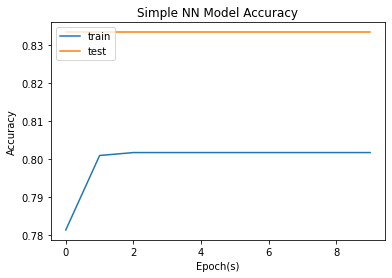

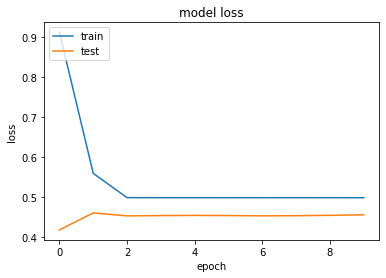

In [65]:
# Plot Accuracy Vs Epochs
plot_acc(simple_nn_hist,title='Simple NN Model Accuracy')

## Medium NN Model

In [67]:
layers = []
layers.append(Dense(128,activation='relu',kernel_initializer='uniform'))
layers.append(BatchNormalization())
layers.append(Dropout(0.5))
layers.append(Dense(64,activation='relu',kernel_initializer='uniform'))
layers.append(Dense(32,activation='relu',kernel_initializer='uniform'))

complex_nn = get_nn_model(layers)

In [68]:
complex_nn_hist = complex_nn.fit_generator(train_generator,epochs=10,validation_data=val_generator)

<ipython-input-68-255165102193>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  complex_nn_hist = complex_nn.fit_generator(train_generator,epochs=10,validation_data=val_generator)


Epoch 1/10
6490/6490 [==============================] - 95s 14ms/step - loss: 0.5290 - acc: 0.8017 - val_loss: 0.4543 - val_acc: 0.8333
Epoch 2/10
6490/6490 [==============================] - 92s 14ms/step - loss: 0.4983 - acc: 0.8017 - val_loss: 0.4542 - val_acc: 0.8333
Epoch 3/10
6490/6490 [==============================] - 91s 14ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4525 - val_acc: 0.8333
Epoch 4/10
6490/6490 [==============================] - 95s 15ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4519 - val_acc: 0.8333
Epoch 5/10
6490/6490 [==============================] - 93s 14ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4548 - val_acc: 0.8333
Epoch 6/10
6490/6490 [==============================] - 93s 14ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4524 - val_acc: 0.8333
Epoch 7/10
6490/6490 [==============================] - 92s 14ms/step - loss: 0.4982 - acc: 0.8017 - val_loss: 0.4536 - val_acc: 0.8333
Epoch 8/10
6490/6490 [==========================

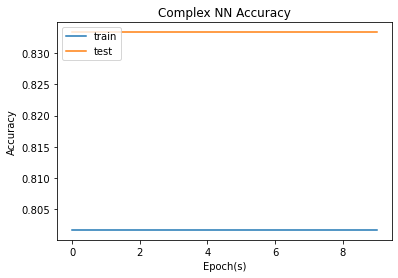

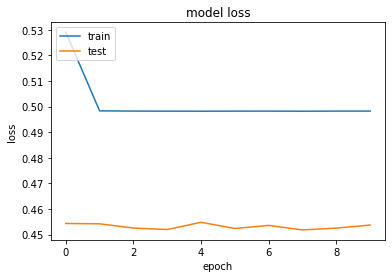

In [69]:
plot_acc(complex_nn_hist,title='Complex NN Accuracy')

## Complex NN Model

In [85]:

L2 = 50
DROP = 0.03
complex_nn_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=input_shape),
    Flatten(),
    keras.layers.Dense(128,input_dim=input_shape[0]*input_shape[1]*input_shape[2]),
    keras.layers.Dense(units=128, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(DROP),
    keras.layers.Dense(units=120, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(DROP),
    keras.layers.Dense(units=100, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(DROP),
    keras.layers.Dense(units=80, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(DROP),
    keras.layers.Dense(units=60, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(.5*DROP),
    keras.layers.Dense(units=40, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
    keras.layers.Dropout(.5*DROP),
    keras.layers.Dense(units=20, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2)),
#     keras.layers.Dropout(DROP),
    keras.layers.Dense(units=num_classes,activation=activation),
])
complex_nn_model.compile(
    keras.optimizers.Adam(lr=0.002), loss=loss_func,
    metrics=["acc"])

In [71]:
cmodel_hist = complex_nn_model.fit_generator(train_generator,epochs=10,validation_data=val_generator)

<ipython-input-71-15a49eb160ae>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cmodel_hist = morooj_model.fit_generator(train_generator,validation_data=val_generator)


6490/6490 [==============================] - 95s 14ms/step - loss: 118.3467 - acc: 0.8005 - val_loss: 0.4594 - val_acc: 0.8333


In [72]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [73]:
x,y = next(trainer(test_generator))
y

array([[1., 0.]])

In [74]:
complex_nn_model.predict(x)

array([[0.786023  , 0.21476665]], dtype=float32)

In [75]:
predict_img(complex_nn_model, '/Users/snouto/Downloads/output2/train/malignant/ISIC_0026909.jpg')

array([[0.786023  , 0.21476665]], dtype=float32)

In [76]:
complex_nn_model.save("/Users/snouto/Downloads/model/skin_cancer.h5")

In [77]:
complex_nn_model.evaluate(test_generator)

1002/1002 [==============================] - 10s 10ms/step - loss: 0.5060 - acc: 0.7974


[0.5060142874717712, 0.7974051833152771]

In [78]:
train_generator , test_generator , val_generator , image_datagen = get_generators()

Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [79]:
x,y = next(trainer(train_generator))

In [80]:
x , y = train_generator[6202]
train_generator.filepaths[6202]
y

array([[1., 0.]], dtype=float32)

In [81]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [82]:
x,y = train_generator[1]
simple_nn.save('/Users/snouto/Downloads/model/skin_cancer.h5')

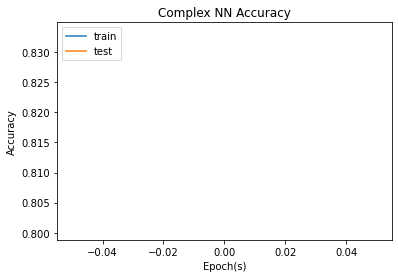

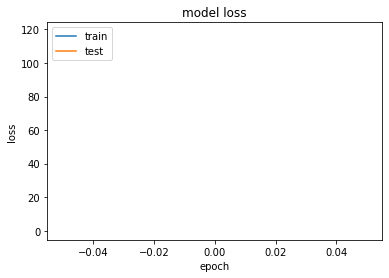

In [83]:
plot_acc(cmodel_hist,title='Complex NN Accuracy')

In [84]:
# This function will prepare CNN model
def prepare_model(kernel_size=(3,3),input_shape=input_shape,pool_size=(2,2),conv_layers=[],mlp_layers=[]):
    from tensorflow import keras
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

    model = Sequential()
    model.add(Conv2D(128,kernel_size=kernel_size,activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    for layer in conv_layers:
        model.add(layer)
    model.add(Flatten())
    # MLP Starts
    model.add(Dense(16, activation='relu'))
    for mlp_layer in mlp_layers:
        model.add(mlp_layer)
    # The final output layer
    model.add(Dense(num_classes, activation=activation))
    model.compile(loss=loss_func,optimizer=keras.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'])
    return model


## Training CNN (Through ImageDataGenerator)

In [59]:
# Creating the training Generator
train_generator , test_generator , val_generator , image_datagen = get_generators()
# create the CNN model
model = prepare_model(input_shape=input_shape)

model_history = model.fit_generator(train_generator,epochs=1,validation_data = val_generator,
                                   callbacks=[
    keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)
])




Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


<ipython-input-59-eb08078d749e>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator,epochs=1,validation_data = val_generator,


6490/6490 [==============================] - 156s 24ms/step - loss: 0.5761 - accuracy: 0.8011 - val_loss: 0.4660 - val_accuracy: 0.8333 - lr: 0.0100


In [60]:
model.evaluate(test_generator)

  16/1002 [..............................] - ETA: 12s - loss: 0.6352 - accuracy: 0.6875

KeyboardInterrupt: 

In [ ]:
x, y = train_generator[6]
model.predict(x)

In [ ]:
counter = 0
for x,y in train_generator:
    if np.argmax(y) != 5:
        print(counter)
        print(train_generator.filepaths[counter])
        break
    counter += 1
    

## Visualizing Simple Convoluted NN (CNN Model)

In [ ]:
ann_viz(model)

## Training Complex CNN Model

In [ ]:
# Get Fresh generators for training
train_generator , test_generator , val_generator , image_datagen = get_generators()
# create the CNN model
cmodel = prepare_model(input_shape=input_shape,conv_layers=[
    Conv2D(64,kernel_size=kernel_size,activation='relu',input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32,kernel_size=kernel_size,activation='relu',input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(16,kernel_size=kernel_size,activation='relu',input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
],mlp_layers=[
    
    Dense(16, activation='relu')
])

cmodel_history = cmodel.fit_generator(train_generator,validation_data = val_generator)

## Visualizing Complex Model (Complex CNN)

In [ ]:
ann_viz(cmodel)

## Prediction using CNN (Simple And Complex) Trained Models

In [ ]:
# Test all test data set 
samples_len = len(test_generator.filenames)
predictions = cmodel.predict_generator(test_generator,steps=samples_len)
predictions

In [ ]:
# Calculate accuracy metrics for complex CNN
loss, acc = cmodel.evaluate_generator(test_generator, steps=samples_len, verbose=0)
acc

# Transfer Learning

Top Layer for Transfer Learning only
-----------------------------------------

In [102]:
def get_toplayer(input_dim=4*4*2048):
    baseline = Sequential([
    Dense(128,input_dim=input_dim,activation='relu',
          kernel_regularizer=rz.l1_l2(l1=1e-5,l2=1e-4),
         bias_regularizer=rz.l2(1e-4),
         activity_regularizer=rz.l2(1e-5)),
    Dropout(0.5),
    Dense(64,activation='relu',kernel_regularizer=rz.l1_l2(l1=1e-5,l2=1e-4),
         bias_regularizer=rz.l2(1e-4),
         activity_regularizer=rz.l2(1e-5)),
    Dense(32,activation='relu',kernel_regularizer=rz.l1_l2(l1=1e-5,l2=1e-4),
         bias_regularizer=rz.l2(1e-4),
         activity_regularizer=rz.l2(1e-5)),
    Dropout(0.5),
    Dense(units=num_classes,activation=activation)
])
    baseline.compile(optimizer='adam',
                     loss=loss_func, metrics=['acc'])
    return baseline
    

In [103]:
def get_pretrained_model(model_name):
    from tensorflow.keras import applications
    """
    This function will return a pretrained model based on its name, possible names: resnet , densenet, vgg16, vgg19, efficientnet
    :param model_name: the name of the pretrained model to return
    :return: an instance of the specified pretrained model
    """
    vargs = dict(include_top=False,weights='imagenet',input_shape=input_shape,classes=num_classes)
    if not model_name:
        return applications.VGG16(**vargs)
    elif model_name == 'resnet':
        return applications.ResNet152V2(**vargs)
    elif model_name == 'densenet':
        return applications.DenseNet201(**vargs)
    elif model_name == 'vgg19':
        return applications.VGG19(**vargs)
    elif model_name == 'efficientnet':
        return applications.EfficientNetB7(**vargs)
    elif model_name == 'mobilenet':
        return applications.MobileNetV2(**vargs)
        
    else:
        return applications.VGG16(**vargs)

In [124]:
def get_features_using_pretrained_model(generator,model,directory,input_shape,sample_count=2000,batch_size=50):
    """
     This function will use an instance of ImageDataGenerator and a Pretrained Model to extract features from the pretrained model for
     the specified sample count and in batches
    :param generator: the ImageDataGenerator to use
    :param model: The specified pretrained model to use
    :param directory: The input directory containing images to extract features from.
    :param sample_count: The number of images to extract and return
    :param batch_size: the number of batches to return in each iteration
    :return: Features and labels
    """
    if None in [generator , model,directory,input_shape]:
        raise Exception("You have to specify ImageDataGenerator , Pretrained Model and a directory before extracting features.")
    shape = (sample_count,) + input_shape
    features = np.zeros(shape=shape)
    labels = np.zeros(shape=(sample_count,num_classes))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [105]:
## Get Trained Model
resnet_pretrained_model = get_pretrained_model('resnet')

In [106]:
resnet_pretrained_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                        

Total params: 58,331,648
Trainable params: 58,187,904
Non-trainable params: 143,744
__________________________________________________________________________________________________


In [107]:
## using Dense Net as pretrained model
densenet_pretrained_model = get_pretrained_model('densenet')

In [108]:
densenet_pretrained_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_13[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                                                                                        

 conv5_block28_0_bn (BatchNorma  (None, 2, 2, 1760)  7040        ['conv5_block27_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block28_0_relu (Activati  (None, 2, 2, 1760)  0           ['conv5_block28_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_1_conv (Conv2D)  (None, 2, 2, 128)    225280      ['conv5_block28_0_relu[0][0]']   
                                                                                                  
 conv5_block28_1_bn (BatchNorma  (None, 2, 2, 128)   512         ['conv5_block28_1_conv[0][0]']   
 lization)                                                                                        
          

In [109]:
efficientnet_pretrained_model = get_pretrained_model('efficientnet')

In [110]:
efficientnet_pretrained_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 3)    0           ['input_14[0][0]']               
                                                                                                  
 normalization (Normalization)  (None, 64, 64, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 65, 65, 3)    0           ['normalization[0][0]']          
                                                                                     

                                                                                                  
 block6k_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6k_se_reshape[0][0]']     
                                                                                                  
 block6k_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6k_se_reduce[0][0]']      
                                                                                                  
 block6k_se_excite (Multiply)   (None, 2, 2, 2304)   0           ['block6k_activation[0][0]',     
                                                                  'block6k_se_expand[0][0]']      
                                                                                                  
 block6k_project_conv (Conv2D)  (None, 2, 2, 384)    884736      ['block6k_se_excite[0][0]']      
                                                                                                  
 block6k_p

In [111]:
vgg16_pretrained_model = get_pretrained_model('vgg16')

In [112]:
vgg16_pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [113]:
vgg19_pretrained_model = get_pretrained_model('vgg19')

In [114]:
vgg19_pretrained_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [115]:
# mobilenet 
mobilenet_pretrained_model = get_pretrained_model('mobilenet')

In [116]:
mobilenet_pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_17[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

## Training using Pretrained Model(s) (Resnet , EfficientNet,VGG16,VGG19,DenseNet)

In [121]:
# 1. Extract different image generators for Train , validation and test data set
train_generator , test_generator , val_generator , img_gen = get_generators()

Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [125]:
# 2. Extract features for the training , validation and test image set using the different image generator declared in step 1 above
current_model = resnet_pretrained_model
samples_count = 500
input_dim = (2, 2, 2048)
#input_dim = (4,4,2560)
# Train Features
train_features , train_labels = get_features_using_pretrained_model(train_generator,model=current_model,input_shape=input_dim,directory=input_dir,sample_count=samples_count,batch_size=batch_size)
# Validation Features
validation_features , validation_labels = get_features_using_pretrained_model(val_generator,model=current_model,input_shape=input_dim,directory=input_dir,sample_count=samples_count,batch_size=batch_size)
# Test Features
test_features , test_labels = get_features_using_pretrained_model(test_generator,model=current_model,input_shape=input_dim,directory=input_dir,sample_count=samples_count,batch_size=batch_size)

KeyboardInterrupt: 

In [ ]:
# reshape for train , validation and test features
final_shape = (samples_count,input_dim[0]*input_dim[1]*input_dim[2])

train_features = np.reshape(train_features,final_shape)
validation_features = np.reshape(validation_features,final_shape)
test_features = np.reshape(test_features,final_shape)

In [ ]:
train_features.shape

In [ ]:
toplayer = get_toplayer(input_dim[0]*input_dim[1]*input_dim[2])

In [ ]:
input_dim[0]*input_dim[1]*input_dim[2]

In [ ]:
train_features.shape

In [ ]:
# Training New MLP on the output convoluted features from pretrained model for 50 epochs
#baseline_hist = toplayer.fit(train_features,train_labels,epochs=100,validation_data=(validation_features,validation_labels))
transfer_hist = complex_nn_model.fit(train_features,train_labels,epochs=100,validation_data=(validation_features,validation_labels))

In [ ]:
# save the model for mobile app
complex_nn_model.save("/Users/snouto/Downloads/model/skin_cancer.h5")

In [ ]:
train_generator.class_indices

## Epochs Vs Accuracy (Transfer Learning)

In [ ]:
plot_acc(transfer_hist,title='Transfer Learning Model Accuracy')

In [ ]:
## Using Callbacks [EarlyStopping] to restore the best weights for MLP training
baseline_hist = complex_nn_model.fit(train_features,train_labels,epochs=50,callbacks=[
    keras.callbacks.EarlyStopping(patience=4,verbose=1,restore_best_weights=True,monitor='accuracy'),
    keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)
],validation_data=(validation_features,validation_labels))

## Using Fine Tuning in Transfer Learning

In [126]:
# 1. Extract different image generators for Train , validation and test data set
train_generator , test_generator , val_generator , _ = get_generators()

Found 6490 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [127]:
from tensorflow.keras.models import Model

current_model = resnet_pretrained_model

# Freeze convolutional layers
for layer in current_model.layers:
    layer.trainable = False

x = current_model.output

x = Flatten()(x)

x = keras.layers.Dense(128,input_dim=input_shape[0]*input_shape[1]*input_shape[2])(x)
x = keras.layers.Dense(units=128, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2))(x)
x = keras.layers.Dropout(DROP)(x)
x = keras.layers.Dense(units=120, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2))(x)
x = keras.layers.Dropout(DROP)(x)
x = keras.layers.Dense(units=100, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2))(x)
x = keras.layers.Dropout(DROP)(x)
x = keras.layers.Dense(units=80, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2))(x)
x = keras.layers.Dropout(DROP)(x)
x = keras.layers.Dense(units=60, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2))(x)
x = keras.layers.Dropout(.5*DROP)(x)
x = keras.layers.Dense(units=40, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2))(x)
x = keras.layers.Dropout(.5*DROP)(x)
x = keras.layers.Dense(units=20, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(L2))(x)
#     keras.layers.Dropout(DROP),
predictions = keras.layers.Dense(units=num_classes,activation=activation)(x)

transfer_finetuning_model = Model(inputs = current_model.input , outputs=predictions)
transfer_finetuning_model.compile('adam',loss=loss_func,metrics=['acc'])

transfer_finetuning_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                            

Total params: 59,440,686
Trainable params: 1,109,038
Non-trainable params: 58,331,648
__________________________________________________________________________________________________


In [128]:
transfer_finetuning_history = transfer_finetuning_model.fit(train_generator,validation_data=val_generator)

6490/6490 [==============================] - 357s 54ms/step - loss: 244.4339 - acc: 0.8014 - val_loss: 0.4540 - val_acc: 0.8333


In [ ]:
# Takes too much time > 5 Hours to complete
#hybrid_model.fit_generator(train_generator,epochs=2,validation_data=val_generator)

# GridSearchCV with Keras

In [ ]:
from keras.wrappers import scikit_learn as k_sklearn
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import optimizers

In [ ]:

model = None
def get_grid_searchable_model(optimizer='sgd',learning_rate=0.01,loss='categorical_crossentropy'):
    model.compile(optimizer=optimizer(learning_rate=learning_rate),loss=loss)
    return model

def perform_grid_search(x,y,epochs=20,callbacks=[]):
    gridSearchable_model = k_sklearn.KerasRegressor(get_grid_searchable_model)
    gridSearch = GridSearchCV(gridSearchable_model,
                              param_grid={
                                  'optimizer': [optimizers.Adam,optimizers.Adamax,optimizers.RMSprop,optimizers.SGD,optimizers.Nadam],
                                  'learning_rate':[0.02,0.03],
                                  'loss':['categorical_crossentropy','kl_divergence']

                              }, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3, verbose=2)

    gridSearch.fit(x,y,epochs=epochs,callbacks=callbacks)